In [9]:
%%capture --no-stderr
%pip install -U langgraph
%pip install openai

In [16]:
import random
import sys

from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain.schema import SystemMessage

# Increase the recursion limit to handle more questions
sys.setrecursionlimit(1500)  # Increase Python's recursion limit

# OpenAI chat model
openai_model = ChatOpenAI(model="gpt-4-turbo", temperature=0.7)

# Game State
class State(TypedDict):
    object_to_guess: str
    questions_asked: Annotated[list, add_messages]
    guesses_asked: Annotated[list, add_messages]
    current_round: int  # Track rounds instead of guess attempts
    max_rounds: int
    winner: str | None
    conversation_log: list  # Added to track conversation
    phase: str  # Track which phase we're in: 'question', 'guess', etc.

# Bot 1: Asks a question
def ask_question(state: State):
    questions = [item.content for item in state['questions_asked']]
    prompt = f"""You are playing 20 Questions. You need to guess the object that the other AI is thinking of. 
    Based on previous answers: {questions}, ask a strategic Yes or No question."""
    
    response = openai_model.invoke([SystemMessage(content=prompt)])
    question = response.content
    
    # Log the question
    print(f"\nQuestion {state['current_round']}: {question}")
    
    # Add to conversation log
    state['conversation_log'].append(f"Q{state['current_round']}: {question}")
    
    return {"questions_asked": [question], "phase": "answer"}

# Bot 2: Answers the question
def answer_question(state: State):
    last_question = state["questions_asked"][-1].content
    prompt = f"""You are playing 20 Questions. You need to answer Yes or No. The question being asked is: [{last_question}]. 
    Only answer with Yes or No. Remember, the object being guessed is: [{state["object_to_guess"].lower()}]"""
    
    response = openai_model.invoke([SystemMessage(content=prompt)])
    answer = response.content

    # Modify the question to include the answer
    question_with_answer = f"{last_question} → {answer}"
    state["questions_asked"][-1].content = question_with_answer
    
    # Log the answer
    print(f"Answer: {answer}")
    
    # Add to conversation log
    state['conversation_log'][-1] = f"Q{state['current_round']}: {last_question} → {answer}"
    
    return {"answer": answer, "phase": "guess"}

# Bot 1: Makes a guess after some questions
def make_guess(state: State):
    questions = [item.content for item in state['questions_asked']]
    guesses = [item.content for item in state['guesses_asked']] if state['guesses_asked'] else []
    
    prompt = f"""You have asked these questions: {questions}. You have made the following guesses: {guesses}. 
    Now make a final guess at what the object is."""
    
    response = openai_model.invoke([SystemMessage(content=prompt)])
    guess = response.content
    
    # Log the guess
    print(f"Guess: {guess}")
    
    # Add to conversation log
    state['conversation_log'].append(f"Guess {state['current_round']}: {guess}")
    
    return {"guesses_asked": [guess], "phase": "check"}

def check_game_over(state: State):
    current_round = state["current_round"]
     
    prompt = f"""You are the judge of 20 questions. The object to guess is: [{state["object_to_guess"].lower()}]
    The guess is: [{state["guesses_asked"][-1].content}] Is the object mentioned in the guess? Please answer with Yes or No."""
    response = openai_model.invoke([SystemMessage(content=prompt)])
   
    correct = "Yes" in response.content
    
    # Increment the round counter
    current_round += 1
    
    if correct:
        print(f"Correct! The answer was: {state['object_to_guess']}")
        return {"winner": "Questioner", "current_round": current_round, "phase": "end"}
    else:
        print(f"Incorrect. Moving to next question...")
        # Check if we've reached max rounds
        if current_round >= state["max_rounds"]:
            return {"current_round": current_round, "phase": "end"}
        else:
            return {"current_round": current_round, "phase": "question"}

# Router function to determine next step based on phase
def router(state: State):
    return state["phase"]

# End Game Node
def end_game(state: State):
    print("\n----- GAME OVER -----")
    print(f"The correct answer was: {state['object_to_guess']}")
    print(f"Winner: {state['winner'] if state['winner'] else 'No one'}")
    
    print("\n----- CONVERSATION LOG -----")
    for entry in state['conversation_log']:
        print(entry)
    
    return {
        "message": f"Game Over! The correct answer was {state['object_to_guess']}. Winner: {state['winner'] if state['winner'] else 'No one'}"
    }

# Create a router node function
def routing_node(state: State):
    # Just pass through the state and let conditional edges handle routing
    return state

# Create Graph
builder = StateGraph(State)

# Add nodes
builder.add_node("ask_question", ask_question)
builder.add_node("answer_question", answer_question)
builder.add_node("make_guess", make_guess)
builder.add_node("check_game_over", check_game_over)
builder.add_node("end_game", end_game)
builder.add_node("router", routing_node)  # Add a routing node using standard add_node

# Set the entry point to the router
builder.set_entry_point("router")

# Add conditional edges from the router node to all other nodes
builder.add_conditional_edges(
    "router",
    router,
    {
        "question": "ask_question",
        "answer": "answer_question",
        "guess": "make_guess",
        "check": "check_game_over",
        "end": "end_game"
    }
)

# All nodes go back to the router
builder.add_edge("ask_question", "router")
builder.add_edge("answer_question", "router")
builder.add_edge("make_guess", "router")
builder.add_edge("check_game_over", "router")

# Compile the graph
graph = builder.compile()

# Print game information
print("\n===== 20 QUESTIONS GAME =====")
object_to_guess = random.choice(["bird", "chair", "refrigerator", "ball", "table", "computer", "book", "phone", "car", "tree"])
print(f"Object to guess (hidden from player): {object_to_guess}")
print(f"Maximum rounds: 10")
print("Game starting...\n")

initial_state: State = {
    "object_to_guess": object_to_guess,
    "questions_asked": [],
    "guesses_asked": [],
    "current_round": 1,
    "max_rounds": 10,
    "winner": None,
    "conversation_log": [],
    "phase": "question"  # Start with question phase
}

# Run the game
result = graph.invoke(initial_state, {"recursion_limit": 100})

# Optionally, print the final state
print("\n----- FINAL STATE -----")
print(f"Questions asked: {len(result['questions_asked'])}")
print(f"Rounds completed: {result['current_round'] - 1}")
print(f"Winner: {result['winner'] if result['winner'] else 'No one'}")



===== 20 QUESTIONS GAME =====
Object to guess (hidden from player): ball
Maximum rounds: 10
Game starting...


Question 1: Is the object you are thinking of something commonly found indoors?
Answer: No.
Guess: Is the object you are thinking of a tree?
Incorrect. Moving to next question...

Question 2: Is the object you are thinking of something that is found in nature?
Answer: No.
Guess: Is the object you are thinking of a car?
Incorrect. Moving to next question...

Question 3: Is the object used primarily for recreational purposes?
Answer: Yes
Guess: Is the object you are thinking of a bicycle?
Incorrect. Moving to next question...

Question 4: Is the object used primarily for sports?
Answer: Yes.
Guess: Is the object you are thinking of a soccer ball?
Correct! The answer was: ball

----- GAME OVER -----
The correct answer was: ball
Winner: Questioner

----- CONVERSATION LOG -----
Q1: Is the object you are thinking of something commonly found indoors? → No.
Guess 1: Is the object you

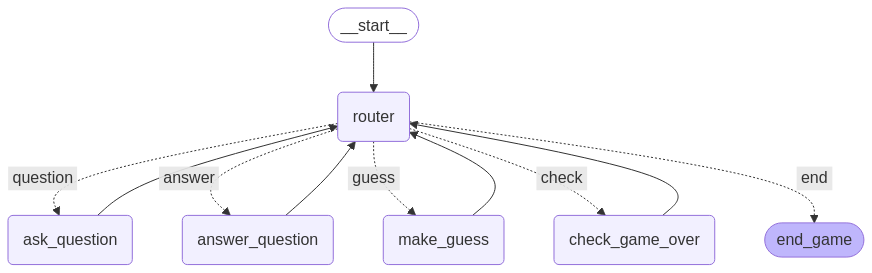

In [12]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))